<a href="https://colab.research.google.com/github/melparc30/earthquake/blob/master/Evacuation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-geojson

In [ ]:
import pandas as pd
import pandas_geojson as pdg
import numpy as np
# For plotting maps
import folium
# For Regular Expressions
import re
# For working with geographical data
import geopandas
# For plotting in python
import matplotlib
import matplotlib.pyplot as plt

### Data

In [ ]:
evac_geo = geopandas.read_file("/content/drive/MyDrive/earthquake/Dataset/ph_evacs_cleaned.geojson")
evac_geo.head()

id            city municipality        place                 province  \
0  2931366            None         None         None                   Cavite   
1  6028843            None         None      Purok 2           Agusan del Sur   
2  8814264  Trece Martires         None  San Agustin                   Cavite   
3  9449210     Mandaluyong         None         None  Eastern Manila District   
4  9668628     Mandaluyong         None         None             Metro Manila   

     type capacity                                           name  \
0  Campus     None  General Emilio Aguinaldo National High School   
1  Campus     None                  San Pascual Elementary School   
2  Campus     None          Trece Martires City Elementary School   
3  Campus     None        Mataas na Paaralang Neptali A. Gonzales   
4   Field     None              Hardin ng Pagasa Botanical Garden   

                                            geometry  
0  POLYGON ((120.94575 14.42849, 120.94563 14.428...  
1  POLYGON ((126.00152 7.96686, 126.00164 7.96704...  
2  POLYGON ((120.86813 14.28636, 120.86893 14.286...  
3  POLYGON ((121.04412 14.58392, 121.04389 14.583...  
4  POLYGON ((121.03653 14.58381, 121.03641 14.583...

<Axes: >

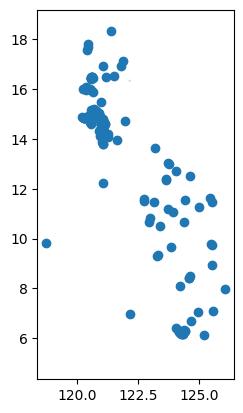

In [ ]:
evac_geo.plot()

# Data Analysis

In [ ]:
evac_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            1576 non-null   object  
 1   city          272 non-null    object  
 2   municipality  20 non-null     object  
 3   place         264 non-null    object  
 4   province      433 non-null    object  
 5   type          1576 non-null   object  
 6   capacity      839 non-null    object  
 7   name          1512 non-null   object  
 8   geometry      1576 non-null   geometry
dtypes: geometry(1), object(8)
memory usage: 110.9+ KB


## Map

In [ ]:
#For Interactive GeoVisualization
import folium
from folium import Map
from folium.map import Layer, FeatureGroup, LayerControl, Marker
from folium.plugins import MarkerCluster, FeatureGroupSubGroup, Fullscreen
from matplotlib.figure import Figure

In [ ]:
fig1 = Figure(figsize=(10, 8.5))  # Map size
# Set location to PH
evacuation_map = folium.Map([12.8797, 121.7740],
                tiles='cartodbpositron',
                zoom_start=5,
                control_scale=True,
                prefer_canvas=True)
# Add fulscreen control
Fullscreen(title="Full Screen",
           title_cancel = "Exit Full Screen",
           force_separate_button=True).add_to(evacuation_map)
display(evacuation_map)

In [ ]:
# Types of evacuation centers in the dataset
evac_types = evac_geo['type'].unique()
evac_types

array(['Campus', 'Field', 'Shelter', 'Church', 'Hospital',
       'Sports Center', 'Barangay Hall'], dtype=object)

In [ ]:
# Create a color dictionary for the markers (for each type of evacuation centers)
color_dict = {"Campus": '#FFC107',
              "Church ": '#1E88E5',
              "Hospital": '#8E7D2E',
              "Barangay Hall": '#004D40',
              "Shelter": '#D81B60',
              "Sports Center": '#6047EF',
              "Field": '#31C7CB'}

In [ ]:
# Add markers for each evacuation center
for _, row in evac_geo.iterrows():
    evac_type = row['type'].strip()  # Remove trailing spaces
    color = color_dict.get(evac_type, 'gray')  # Default to gray if type not in color_dict

    # Get the centroid of the geometry
    centroid = row.geometry.centroid

    folium.CircleMarker(
        location=[centroid.y, centroid.x],  # Use centroid coordinates
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(f"{evac_type}", parse_html=True)
    ).add_to(evacuation_map)

# Show map
evacuation_map

# Existing and Recommended Evacuation Centers

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import json
import os

# Load recommended centers
recommended_centers = pd.read_csv('/content/drive/MyDrive/earthquake/recommended_evacuation_centers.csv')

# OPTIONAL: Check if coordinates are flipped (only needed once)
# Swap if necessary (for example, if Lat < 10 and Long > 100)
if (recommended_centers['Latitude'].mean() > recommended_centers['Longitude'].mean()):
    recommended_centers[['Latitude', 'Longitude']] = recommended_centers[['Longitude', 'Latitude']]

# Load existing evacuation centers
evac_geo = gpd.read_file('/content/drive/MyDrive/earthquake/Dataset/ph_evacs_cleaned.geojson')

# Create a color dictionary for known types
color_dict = {
    'School': 'blue',
    'Gymnasium': 'green',
    'Community Center': 'orange',
    'Hospital': 'red',
    'Church': 'purple',
    'Government Building': 'darkblue',
    'Sports Complex': 'darkgreen',
    'Public Park': 'darkred',
    'Municipal Hall': 'cadetblue',
    'Covered Court': 'darkpurple',
    'Recommended': 'darkred'
}

# OPTIONAL: Filter recommended centers to keep only those on land (requires PH boundary file)
# Load PH boundaries if available
ph_boundary_path = '/content/drive/MyDrive/earthquake/philippines_boundary.geojson'
if os.path.exists(ph_boundary_path):
    ph_bounds = gpd.read_file(ph_boundary_path)

    # Create GeoDataFrame for recommended centers
    geometry = [Point(xy) for xy in zip(recommended_centers['Longitude'], recommended_centers['Latitude'])]
    recommended_gdf = gpd.GeoDataFrame(recommended_centers, geometry=geometry, crs="EPSG:4326")

    # Keep only those within the land area
    recommended_gdf = gpd.sjoin(recommended_gdf, ph_bounds, predicate='within')
else:
    # If no boundary file is available, just use the raw coordinates
    geometry = [Point(xy) for xy in zip(recommended_centers['Longitude'], recommended_centers['Latitude'])]
    recommended_gdf = gpd.GeoDataFrame(recommended_centers, geometry=geometry, crs="EPSG:4326")

# Combine for calculating map center
all_points = pd.concat([evac_geo, recommended_gdf])
center_lat = all_points.geometry.centroid.y.mean()
center_lon = all_points.geometry.centroid.x.mean()

# Create the base map
evacuation_map = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles='OpenStreetMap')

# Add existing evacuation centers
for _, row in evac_geo.iterrows():
    evac_type = row['type'].strip()
    color = color_dict.get(evac_type, 'gray')
    centroid = row.geometry.centroid

    popup_content = f"""
    <b>Type:</b> {evac_type}<br>
    <b>Name:</b> {row['name']}<br>
    <b>Coordinates:</b> {centroid.y:.6f}, {centroid.x:.6f}
    """

    folium.CircleMarker(
        location=[centroid.y, centroid.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(evacuation_map)

# Add recommended evacuation centers
for _, row in recommended_gdf.iterrows():
    popup_content = f"""
    <b>Location:</b> {row['Location']}<br>
    <b>Distance from Centroid:</b> {row['Distance_from_Centroid']} km<br>
    <b>Cluster:</b> {row['Cluster']}<br>
    <b>Coordinates:</b> {row['Latitude']:.6f}, {row['Longitude']:.6f}
    """

    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        color='black',
        weight=2,
        fill=True,
        fill_color=color_dict['Recommended'],
        fill_opacity=0.9,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(evacuation_map)

# --------- Build Legend ---------
legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px; width: 200px; height: auto;
            border:2px solid grey; z-index:9999; font-size:12px;
            background-color:white;
            padding: 10px;
            border-radius: 5px;">
    <p style="margin-top: 0; margin-bottom: 5px;"><b>Legend</b></p>
'''

# Get unique types from dataset
unique_types = evac_geo['type'].str.strip().unique()

# Add all types with color or default gray
for evac_type in unique_types:
    evac_type = evac_type.strip()
    color = color_dict.get(evac_type, 'gray')
    legend_html += f'''
    <p style="margin-top: 0; margin-bottom: 5px;">
        <i class="fa fa-circle" style="color:{color}"></i> {evac_type}
    </p>'''

# Add Recommended explicitly
legend_html += f'''
<p style="margin-top: 0; margin-bottom: 5px;">
    <i class="fa fa-circle" style="color:{color_dict['Recommended']}"></i> Recommended
</p>'''

legend_html += '</div>'

# Add legend to map
evacuation_map.get_root().html.add_child(folium.Element(legend_html))

# Save and display map
evacuation_map.save('evacuation_centers_map.html')
evacuation_map


<ipython-input-7-6c83ed3b5d0c>:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = all_points.geometry.centroid.y.mean()
<ipython-input-7-6c83ed3b5d0c>:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = all_points.geometry.centroid.x.mean()


In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import os

In [ ]:
!pip install geopandas requests

In [ ]:
# Download Philippines boundary GeoJSON if not already present
boundary_url = "https://raw.githubusercontent.com/faeldon/philippines-json-maps/master/geojson/philippines-provinces.geojson"
boundary_file = "/content/drive/MyDrive/earthquake/Dataset/ph_boundary.geojson"

if not os.path.exists(boundary_file):
    print("Downloading Philippines boundary GeoJSON...")
    r = requests.get(boundary_url)
    with open(boundary_file, 'wb') as f:
        f.write(r.content)
    print("Download complete.")

In [ ]:


# -------------------------------
# 1. Load Data
# -------------------------------
recommended_centers = pd.read_csv('/content/drive/MyDrive/earthquake/recommended_evacuation_centers.csv')

evac_geo = gpd.read_file('/content/drive/MyDrive/earthquake/Dataset/ph_evacs_cleaned.geojson')


# Load Philippines boundary for filtering and locking view
# Load JSON into a DataFrame
with open("/content/drive/MyDrive/earthquake/Dataset/country.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Create geometry from lat/lon
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Save as GeoJSON
gdf.to_file("/content/drive/MyDrive/earthquake/Dataset/evac_centers.geojson", driver="GeoJSON")

# -------------------------------
# 2. Categorize Custom Types
# -------------------------------
def categorize_type(raw_type):
    raw = raw_type.lower()
    if any(word in raw for word in ['school', 'childcare', 'kindergarten', 'college', 'university']):
        return 'Campus'
    elif any(word in raw for word in ['church', 'place_of_worship']):
        return 'Church'
    elif any(word in raw for word in ['clinic', 'health_post', 'hospital']):
        return 'Hospital'
    elif any(word in raw for word in ['community_centre', 'events_venue', 'marketplace', 'town_hall', 'police']):
        return 'Barangay Hall'
    elif any(word in raw for word in ['shelter', 'social_facility']):
        return 'Shelter'
    elif any(word in raw for word in ['sports', 'covered court']):
        return 'Sports Center'
    elif any(word in raw for word in ['field']):
        return 'Field'
    else:
        return 'Other'

# Apply category
evac_geo['category'] = evac_geo['type'].apply(categorize_type)

# -------------------------------
# 3. Filter Recommended Points in Water
# -------------------------------
# Ensure recommended centers are inside PH boundary
geometry = [Point(xy) for xy in zip(recommended_centers['Longitude'], recommended_centers['Latitude'])]
recommended_gdf = gpd.GeoDataFrame(recommended_centers, geometry=geometry, crs="EPSG:4326")

# Spatial join: keep only points inside PH boundary
recommended_gdf = gpd.sjoin(recommended_gdf, ph_boundary, predicate='within')

# -------------------------------
# 4. Color Dictionary for Categories
# -------------------------------
category_colors = {
    'Campus': 'blue',
    'Church': 'purple',
    'Hospital': 'red',
    'Barangay Hall': 'cadetblue',
    'Shelter': 'darkorange',
    'Sports Center': 'green',
    'Field': 'lightgreen',
    'Other': 'gray',
    'Recommended': 'black'
}

# -------------------------------
# 5. Create Map
# -------------------------------
bounds = ph_boundary.total_bounds
map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]

evac_map = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Lock view to the Philippines
evac_map.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# -------------------------------
# 6. Add Existing Evacuation Centers
# -------------------------------
for _, row in evac_geo.iterrows():
    category = row['category']
    color = category_colors.get(category, 'gray')
    point = row.geometry.centroid

    popup = f"""
    <b>Name:</b> {row['name']}<br>
    <b>Type:</b> {row['type']}<br>
    <b>Category:</b> {category}<br>
    <b>Coordinates:</b> {point.y:.6f}, {point.x:.6f}
    """
    folium.CircleMarker(
        location=[point.y, point.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=popup
    ).add_to(evac_map)

# -------------------------------
# 7. Add Recommended Centers
# -------------------------------
for _, row in recommended_gdf.iterrows():
    popup = f"""
    <b>Location:</b> {row['Location']}<br>
    <b>Distance:</b> {row['Distance_from_Centroid']} km<br>
    <b>Cluster:</b> {row['Cluster']}<br>
    <b>Coordinates:</b> {row['Latitude']:.6f}, {row['Longitude']:.6f}
    """
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        color='black',
        weight=2,
        fill=True,
        fill_color=category_colors['Recommended'],
        fill_opacity=0.9,
        popup=popup
    ).add_to(evac_map)

# -------------------------------
# 8. Add Legend
# -------------------------------
legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px; width: 220px; height: auto;
            border:2px solid grey; z-index:9999; font-size:12px;
            background-color:white;
            padding: 10px;
            border-radius: 5px;">
    <p style="margin: 0 0 5px 0;"><b>Legend</b></p>
'''

for cat, color in category_colors.items():
    legend_html += f'''
    <p style="margin: 0;">
        <i class="fa fa-circle" style="color:{color}; margin-right:5px;"></i> {cat}
    </p>'''

legend_html += '</div>'
evac_map.get_root().html.add_child(folium.Element(legend_html))

# -------------------------------
# 9. Save and Display
# -------------------------------
evac_map.save('evacuation_centers_map.html')
evac_map


KeyError: 'lon'

In [ ]:
print(len(evac_geo))

1576


## Evacuation Centers and Earthquake Hotspots

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster


In [ ]:
# Load earthquake data
eq_df = pd.read_csv('/content/drive/MyDrive/earthquake/Dataset/phivolcs_earthquake_data.csv')

# Filter rows with missing lat/lon
eq_df = eq_df.dropna(subset=['Latitude', 'Longitude'])

# Load evacuation centers
evac_gdf = gpd.read_file('/content/drive/MyDrive/earthquake/Dataset/ph_evacs_cleaned.geojson')

# Initialize folium map centered on the Philippines
philippines_center = [12.8797, 121.774]
eq_map = folium.Map(location=philippines_center, zoom_start=6, tiles='cartodbpositron')

# Add earthquake data with marker cluster
eq_cluster = MarkerCluster(name="Earthquakes").add_to(eq_map)

for _, row in eq_df.iterrows():
    mag = row['Magnitude']
    location = [row['Latitude'], row['Longitude']]
    popup_text = f"Magnitude: {mag}<br>Date: {row['Date']}" if 'Date' in row else f"Magnitude: {mag}"

    # Color by magnitude
    if mag >= 6.0:
        color = 'red'
    elif mag >= 5.0:
        color = 'orange'
    else:
        color = 'blue'

    folium.CircleMarker(
        location=location,
        radius=4 + mag,  # slightly scale with magnitude
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(eq_cluster)

# Add evacuation centers with colored markers
color_dict = {
    "Campus": '#FFC107',
    "Church": '#1E88E5',
    "Hospital": '#8E7D2E',
    "Barangay Hall": '#004D40',
    "Shelter": '#D81B60',
    "Sports Center": '#6047EF',
    "Field": '#31C7CB'
}

evac_layer = folium.FeatureGroup(name="Evacuation Centers").add_to(eq_map)

for _, row in evac_gdf.iterrows():
    evac_type = row['type'].strip()
    color = color_dict.get(evac_type, 'gray')
    centroid = row.geometry.centroid
    folium.CircleMarker(
        location=[centroid.y, centroid.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(f"Type: {evac_type}", max_width=200)
    ).add_to(evac_layer)

# Add Layer Control
folium.LayerControl().add_to(eq_map)

# Save the map to HTML
eq_map.save("earthquake_evacuation_dashboard.html")
print("Dashboard saved as 'earthquake_evacuation_dashboard.html'")


ValueError: Location should consist of two numerical values, but '-' of type <class 'str'> is not convertible to float.